In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

Matplotlib is building the font cache; this may take a moment.


In [24]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *
from src.layers import *

## Data

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2018-01', '2018-12'),
    val_days=5,
    split='train',
    tp_log=1,
#     pure_sr_ratio=8
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2018-01', '2018-12'),
    val_days=5,
    split='valid',
    tp_log=1,
#     pure_sr_ratio=8
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid))

In [8]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=32, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=32, sampler=sampler_valid)

In [9]:
len(ds_train), len(dl_train)

(20988, 656)

In [10]:
X, y = ds_train[0]

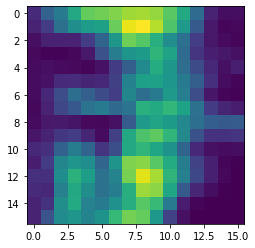

In [11]:
plt.imshow(X[0])

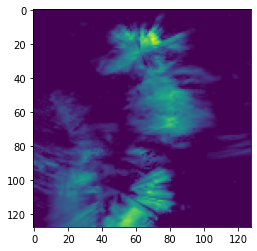

In [12]:
plt.imshow(y[0])

## Leinonen-like architecture

In [13]:
gen = Generator(
    nres=3, nf_in=1, nf=256, use_noise=True, spectral_norm=True
).to(device)

In [33]:
disc = Discriminator2(
    nf=256, nres=3, sigmoid=False, spectral_norm=True
).to(device)

In [27]:
count_parameters(gen)/1e6, count_parameters(disc)/1e6

(4.167607, 4.888513)

In [28]:
betas = (0.5, 0.9)
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=1e-4, betas=betas)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=betas)

In [37]:
X_sample, y_sample = next(iter(dl_train))

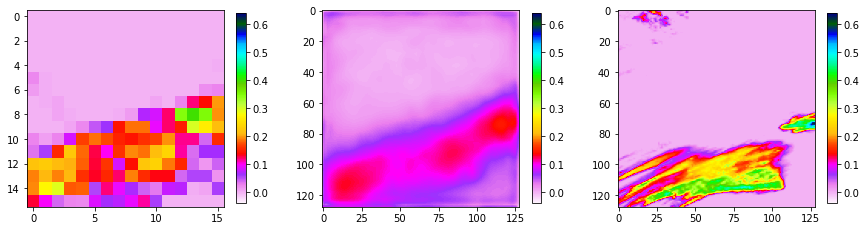

In [38]:
plot_sample(X_sample, y_sample, gen, 0)

## Pretraining

In [39]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [40]:
trainer = Trainer(gen, optimizer, criterion, dl_train, dl_valid)

In [41]:
trainer.fit(1)

In [42]:
# torch.save(gen.state_dict(), f'gen_pretrained_sn.pt')
# gen.load_state_dict(torch.load('gen_pretrained.pt'))

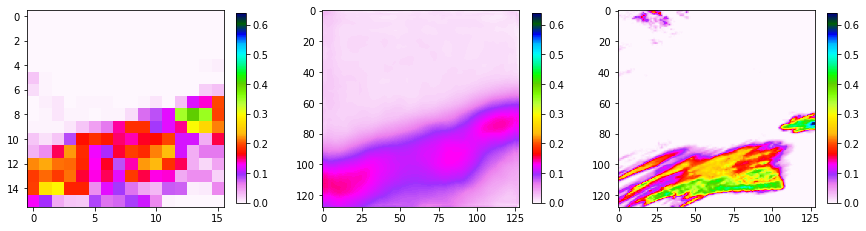

In [43]:
plot_sample(X_sample, y_sample, gen, 0)

## GAN

In [44]:
trainer = GANTrainer(
    gen, disc, gen_optimizer, disc_optimizer, dl_train, disc_repeats=5, l_loss='l1', 
    adv_loss_type='Wasserstein', gp_lambda=10,
    l_lambda=5, plot=True, plotting_sample=(X_sample, y_sample)
)

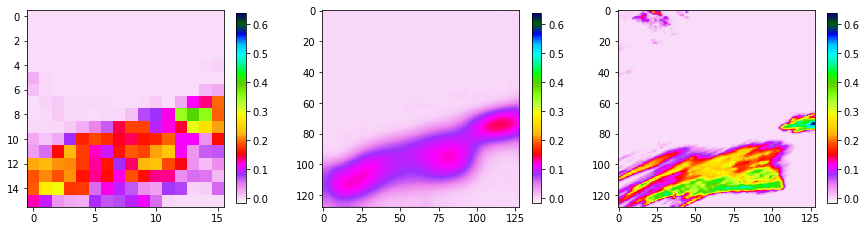

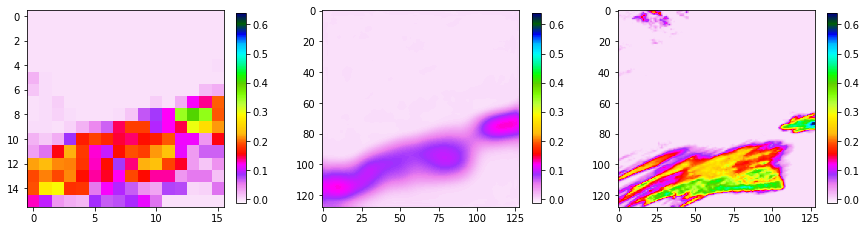

KeyboardInterrupt: 

In [45]:
trainer.fit(10)

In [55]:
trainer.fit(10)

> /home/stephan/nwp-downscale/notebooks/Experiments/src/trainer.py(247)fit()
    245                     pdb.set_trace()
    246                     # Train discriminator
--> 247                     self.disc_optimizer.zero_grad()
    248 
    249                     fake = self.gen(X)



ipdb>  n


> /home/stephan/nwp-downscale/notebooks/Experiments/src/trainer.py(249)fit()
    247                     self.disc_optimizer.zero_grad()
    248 
--> 249                     fake = self.gen(X)
    250                     preds_real = self.disc([X, real])
    251                     preds_fake = self.disc([X, fake.detach()])



ipdb>  n


/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


> /home/stephan/nwp-downscale/notebooks/Experiments/src/trainer.py(250)fit()
    248 
    249                     fake = self.gen(X)
--> 250                     preds_real = self.disc([X, real])
    251                     preds_fake = self.disc([X, fake.detach()])
    252                     self.disc_preds_real.append(preds_real.detach().cpu().numpy())



ipdb>  n


> /home/stephan/nwp-downscale/notebooks/Experiments/src/trainer.py(251)fit()
    249                     fake = self.gen(X)
    250                     preds_real = self.disc([X, real])
--> 251                     preds_fake = self.disc([X, fake.detach()])
    252                     self.disc_preds_real.append(preds_real.detach().cpu().numpy())
    253                     self.disc_preds_fake.append(preds_fake.detach().cpu().numpy())



ipdb>  n


> /home/stephan/nwp-downscale/notebooks/Experiments/src/trainer.py(252)fit()
    250                     preds_real = self.disc([X, real])
    251                     preds_fake = self.disc([X, fake.detach()])
--> 252                     self.disc_preds_real.append(preds_real.detach().cpu().numpy())
    253                     self.disc_preds_fake.append(preds_fake.detach().cpu().numpy())
    254 



ipdb>  preds_real


tensor([[0.0314],
        [0.0296],
        [0.0291],
        [0.0288],
        [0.0296],
        [0.0288],
        [0.0290],
        [0.0288],
        [0.0288],
        [0.0288],
        [0.0304],
        [0.0293],
        [0.0290],
        [0.0290],
        [0.0298],
        [0.0297],
        [0.0290],
        [0.0292],
        [0.0291],
        [0.0295],
        [0.0288],
        [0.0296],
        [0.0288],
        [0.0292],
        [0.0299],
        [0.0297],
        [0.0292],
        [0.0293],
        [0.0304],
        [0.0300],
        [0.0300],
        [0.0312]], device='cuda:0', grad_fn=<AddmmBackward>)


ipdb>  n


> /home/stephan/nwp-downscale/notebooks/Experiments/src/trainer.py(253)fit()
    251                     preds_fake = self.disc([X, fake.detach()])
    252                     self.disc_preds_real.append(preds_real.detach().cpu().numpy())
--> 253                     self.disc_preds_fake.append(preds_fake.detach().cpu().numpy())
    254 
    255                     disc_loss = self._disc_loss(preds_real, preds_fake)



ipdb>  n


> /home/stephan/nwp-downscale/notebooks/Experiments/src/trainer.py(255)fit()
    253                     self.disc_preds_fake.append(preds_fake.detach().cpu().numpy())
    254 
--> 255                     disc_loss = self._disc_loss(preds_real, preds_fake)
    256 
    257                     if self.gp_lambda:



ipdb>  n


> /home/stephan/nwp-downscale/notebooks/Experiments/src/trainer.py(257)fit()
    255                     disc_loss = self._disc_loss(preds_real, preds_fake)
    256 
--> 257                     if self.gp_lambda:
    258                         epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
    259                         gradient = get_gradient(self.disc, X, real, fake.detach(), epsilon)



ipdb>  disc_loss


tensor(-3.2080e-05, device='cuda:0', grad_fn=<AddBackward0>)


ipdb>  n


> /home/stephan/nwp-downscale/notebooks/Experiments/src/trainer.py(258)fit()
    256 
    257                     if self.gp_lambda:
--> 258                         epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
    259                         gradient = get_gradient(self.disc, X, real, fake.detach(), epsilon)
    260                         gp = gradient_penalty(gradient)



ipdb>  n


> /home/stephan/nwp-downscale/notebooks/Experiments/src/trainer.py(259)fit()
    257                     if self.gp_lambda:
    258                         epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
--> 259                         gradient = get_gradient(self.disc, X, real, fake.detach(), epsilon)
    260                         gp = gradient_penalty(gradient)
    261                         disc_loss += self.gp_lambda * gp



ipdb>  n


> /home/stephan/nwp-downscale/notebooks/Experiments/src/trainer.py(260)fit()
    258                         epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
    259                         gradient = get_gradient(self.disc, X, real, fake.detach(), epsilon)
--> 260                         gp = gradient_penalty(gradient)
    261                         disc_loss += self.gp_lambda * gp
    262 



ipdb>  n


> /home/stephan/nwp-downscale/notebooks/Experiments/src/trainer.py(261)fit()
    259                         gradient = get_gradient(self.disc, X, real, fake.detach(), epsilon)
    260                         gp = gradient_penalty(gradient)
--> 261                         disc_loss += self.gp_lambda * gp
    262 
    263                     mean_disc_loss += disc_loss.item() / self.disc_repeats



ipdb>  gp


tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)


ipdb>  q


BdbQuit: 

In [46]:
X, y = next(iter(dl_train))

In [47]:
preds = trainer.gen(X.to(device))

In [49]:
disc_preds = trainer.disc([X.to(device), preds])

In [54]:
disc_preds.mean()

tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>)

In [52]:
disc_real = trainer.disc([X.to(device), y.to(device)])

In [53]:
disc_real

tensor([[0.0314],
        [0.0294],
        [0.0310],
        [0.0288],
        [0.0301],
        [0.0296],
        [0.0296],
        [0.0290],
        [0.0291],
        [0.0296],
        [0.0294],
        [0.0299],
        [0.0288],
        [0.0306],
        [0.0305],
        [0.0288],
        [0.0292],
        [0.0298],
        [0.0306],
        [0.0297],
        [0.0301],
        [0.0290],
        [0.0290],
        [0.0298],
        [0.0295],
        [0.0300],
        [0.0302],
        [0.0313],
        [0.0308],
        [0.0290],
        [0.0297],
        [0.0296]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.plot(trainer.train_gen_losses); ax1.set_title('Generator loss')
ax2.plot(trainer.train_l_losses); ax2.set_title('L1 loss')
ax3.plot(trainer.train_disc_losses); ax3.set_title('Disc loss')

In [ ]:
# plt.plot(trainer.train_gen_losses, label='gen')
# plt.plot(trainer.train_l_losses, label='l_loss')
plt.plot(trainer.train_disc_losses, label='disc')
plt.legend()

In [ ]:
X, y = next(iter(dl_train))
for i in range(5):
    plot_sample(X, y, gen, i)

In [ ]:
X, y = next(iter(dl_valid))
for i in range(5):
    plot_sample(X, y, gen, i)

In [ ]:
plt.hist(trainer.disc_preds_real[-1])
plt.hist(trainer.disc_preds_fake[-1])
plt.hist(trainer.gen_preds_fake[-1])

In [ ]:
import pickle

In [ ]:
with open('11.trainer', 'wb') as f:
    pickle.dump(trainer, f)